In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers
from keras.layers import Dropout

In [0]:
df = pd.read_csv('for_google_colab.csv')

In [283]:
#EDA
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,728790,NaN,NaN,NaN,364394,210384,0,182197,364394,546592,728789
ab_id,728790,NaN,NaN,NaN,2.01909e+09,53567.6,2.019e+09,2.01905e+09,2.01909e+09,2.01914e+09,2.01919e+09
b_score,728790,NaN,NaN,NaN,2.44753,2.716,0,0,2,4,23
outs,728790,NaN,NaN,NaN,0.981217,0.817515,0,0,1,2,2
pitch_num,728790,NaN,NaN,NaN,2.92589,1.74247,1,1,3,4,16
pitch_type,728790,13,FF,261485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
g_id,728790,NaN,NaN,NaN,2.01901e+08,695.59,2.019e+08,2.01901e+08,2.01901e+08,2.01902e+08,2.01902e+08
p_score,728790,NaN,NaN,NaN,2.48709,2.81248,0,0,2,4,23
stand,728790,2,R,427099,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event,124860,43,Strikeout,42185,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Pitch Type Distribution')

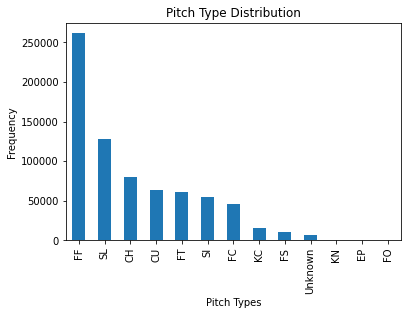

In [284]:
#Pitch type distribution
plot = df['pitch_type'].value_counts().plot(kind='bar')
plot.set_xlabel('Pitch Types')
plot.set_ylabel('Frequency')
plot.set_title('Pitch Type Distribution')

Text(0.5, 1.0, 'At-Bat Count Distribution')

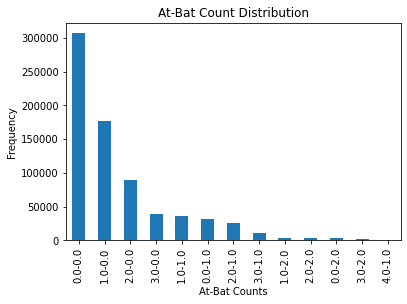

In [285]:
#Count distribution
plot = df['count'].value_counts().plot(kind='bar')
plot.set_xlabel('At-Bat Counts')
plot.set_ylabel('Frequency')
plot.set_title('At-Bat Count Distribution')

Text(0.5, 1.0, 'Run Differential Distribution')

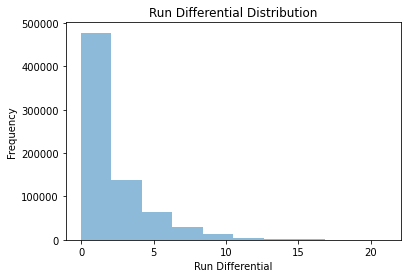

In [286]:
##run diff
plt.hist(df['run diff'], bins=10, alpha=0.5)
plt.xlabel('Run Differential')
plt.ylabel('Frequency')
plt.title('Run Differential Distribution')

Text(0.5, 1.0, 'High Stress Situation Distribution')

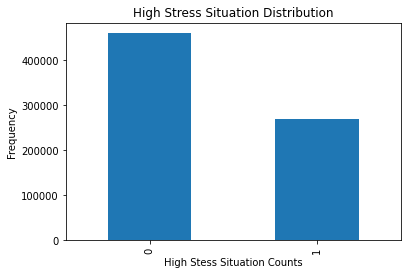

In [287]:
#HSS distribution
plot = df['HSS'].value_counts().plot(kind='bar')
plot.set_xlabel('High Stess Situation Counts')
plot.set_ylabel('Frequency')
plot.set_title('High Stress Situation Distribution')

In [0]:
##Let's focus on a few individuals 

In [0]:
deGrom = df.loc[df['pitcher_id'] == 594798]
deGrom.shape

(3298, 17)

In [0]:
deGrom = deGrom.drop(['ab_id', 'b_score', 'p_score', 'g_id', 'pitcher_id', 'Unnamed: 0'], axis=1)


In [0]:
deGrom.columns

Index(['outs', 'pitch_num', 'pitch_type', 'stand', 'event', 'top', 'inning',
       'count', 'run diff', 'HSS', 'next_pitch'],
      dtype='object')

In [0]:
deGrom.isna().any()

outs          False
pitch_num     False
pitch_type    False
stand         False
event          True
top           False
inning        False
count         False
run diff      False
HSS           False
next_pitch    False
dtype: bool

In [0]:
deGrom['event'].fillna('Pitch Thrown', inplace=True)


In [0]:
deGrom.isna().any()

outs          False
pitch_num     False
pitch_type    False
stand         False
event         False
top           False
inning        False
count         False
run diff      False
HSS           False
next_pitch    False
dtype: bool

In [0]:
deGrom['pitch_type'].value_counts()

FF         1536
SL         1022
CH          506
Unknown     107
CU           93
FT           34
Name: pitch_type, dtype: int64

In [0]:
deGrom['next_pitch'].value_counts()

FF         1514
SL          999
CH          505
Unknown     107
CU           93
FT           55
FC           12
SI           10
KC            3
Name: next_pitch, dtype: int64

In [0]:
deGrom = deGrom[deGrom.pitch_type != 'Unknown']
deGrom = deGrom[(deGrom.next_pitch != 'Unknown')]
deGrom = deGrom[(deGrom.next_pitch != 'FC')]
deGrom = deGrom[(deGrom.next_pitch != 'SI')]
deGrom = deGrom[(deGrom.next_pitch != 'KC')]

In [0]:
deGrom['pitch_type'].value_counts()

FF    1526
SL    1011
CH     500
CU      93
FT      34
Name: pitch_type, dtype: int64

In [0]:
deGrom['next_pitch'].value_counts()

FF    1513
SL     999
CH     504
CU      93
FT      55
Name: next_pitch, dtype: int64

In [0]:
x = deGrom.drop(['next_pitch'], axis=1)

In [0]:
y = deGrom['next_pitch']

In [0]:
print('X Shape', x.shape)
print ('Y Shape', y.shape)

X Shape (3164, 10)
Y Shape (3164,)


In [0]:
x.head()

,outs,pitch_num,pitch_type,stand,event,top,inning,count,run diff,HSS
3034,0.0,1.0,FF,L,Pitch Thrown,0.0,1.0,0.0-0.0,1.0,0
3035,0.0,2.0,FF,L,Pop Out,0.0,1.0,0.0-0.0,1.0,0
3036,1.0,1.0,FF,R,Pitch Thrown,0.0,1.0,0.0-0.0,1.0,0
3037,1.0,2.0,SL,R,Pitch Thrown,0.0,1.0,0.0-0.0,1.0,0
3038,1.0,3.0,FF,R,Pitch Thrown,0.0,1.0,1.0-0.0,1.0,0


In [0]:
#Time to encode Y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_y)


In [0]:
x = pd.get_dummies(x, columns=['outs', 'pitch_type', 'stand', 'event', 'top', 'inning', 'count', 'HSS'])

In [0]:
x.columns

Index(['pitch_num', 'run diff', 'outs_0.0', 'outs_1.0', 'outs_2.0',
       'pitch_type_CH', 'pitch_type_CU', 'pitch_type_FF', 'pitch_type_FT',
       'pitch_type_SL', 'stand_L', 'stand_R', 'event_Batter Interference',
       'event_Bunt Groundout', 'event_Bunt Pop Out',
       'event_Caught Stealing 2B', 'event_Double Play',
       'event_Fielders Choice Out', 'event_Flyout', 'event_Forceout',
       'event_Grounded Into DP', 'event_Groundout', 'event_Lineout',
       'event_Pitch Thrown', 'event_Pop Out', 'event_Sac Bunt',
       'event_Sac Fly', 'event_Single', 'event_Strikeout', 'top_0.0',
       'top_1.0', 'inning_1.0', 'inning_2.0', 'inning_3.0', 'inning_4.0',
       'inning_5.0', 'inning_6.0', 'inning_7.0', 'inning_8.0', 'inning_9.0',
       'count_0.0-0.0', 'count_0.0-1.0', 'count_0.0-2.0', 'count_1.0-0.0',
       'count_1.0-1.0', 'count_1.0-2.0', 'count_2.0-0.0', 'count_2.0-1.0',
       'count_2.0-2.0', 'count_3.0-0.0', 'count_3.0-1.0', 'count_3.0-2.0',
       'HSS_0', 'HSS_1']

In [0]:
x.shape

(3164, 54)

In [0]:
dummy_y

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [0]:
#split data into train/test

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.2, random_state=92)

In [0]:
print('X Train Shape', x_train.shape)
print('X Test Shape', x_test.shape)
print('Y Train Shape', y_train.shape)
print('Y Test Shape', y_test.shape)

X Train Shape (2531, 54)
X Test Shape (633, 54)
Y Train Shape (2531, 5)
Y Test Shape (633, 5)


In [0]:
#use this for deGrom

model = Sequential()
model.add(Dense(108, input_dim=54, kernel_initializer = 'uniform', activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(54, activation='hard_sigmoid'))
model.add(Dense(27, activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='sigmoid'))

In [0]:
#optimizer = keras.optimizers.adam(lr=0.3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

Train on 2531 samples, validate on 633 samples
Epoch 1/10
2531/2531 [==============================] - 1s 309us/step - loss: 1.2675 - accuracy: 0.4512 - val_loss: 1.1788 - val_accuracy: 0.5055
Epoch 2/10
2531/2531 [==============================] - 1s 236us/step - loss: 1.2100 - accuracy: 0.4698 - val_loss: 1.1707 - val_accuracy: 0.5055
Epoch 3/10
2531/2531 [==============================] - 1s 300us/step - loss: 1.2093 - accuracy: 0.4714 - val_loss: 1.1725 - val_accuracy: 0.5055
Epoch 4/10
2531/2531 [==============================] - 1s 271us/step - loss: 1.2049 - accuracy: 0.4714 - val_loss: 1.1677 - val_accuracy: 0.5055
Epoch 5/10
2531/2531 [==============================] - 1s 214us/step - loss: 1.2053 - accuracy: 0.4714 - val_loss: 1.1687 - val_accuracy: 0.5055
Epoch 6/10
2531/2531 [==============================] - 1s 213us/step - loss: 1.1978 - accuracy: 0.4714 - val_loss: 1.1615 - val_accuracy: 0.5055
Epoch 7/10
2531/2531 [==============================] - 1s 205us/step - loss:

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 108)               5940      
_________________________________________________________________
dropout_1 (Dropout)          (None, 108)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 54)                5886      
_________________________________________________________________
dense_3 (Dense)              (None, 27)                1485      
_________________________________________________________________
dropout_2 (Dropout)          (None, 27)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 140       
Total params: 13,451
Trainable params: 13,451
Non-trainable params: 0
__________________________________________________

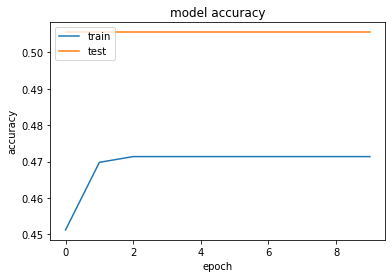

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

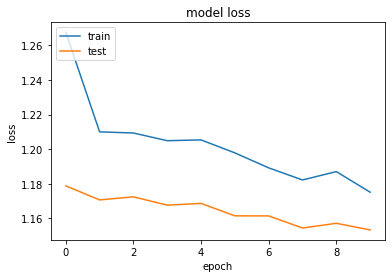

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Trevor Bauer

In [0]:
bauer = df.loc[df['pitcher_id'] == 545333]
bauer.shape

(3687, 17)

In [0]:
bauer= bauer.drop(['ab_id', 'b_score', 'p_score', 'g_id', 'pitcher_id', 'Unnamed: 0'], axis=1)


In [0]:
bauer['event'].fillna('Pitch Thrown', inplace=True)


In [0]:
bauer.isna().any()

outs          False
pitch_num     False
pitch_type    False
stand         False
event         False
top           False
inning        False
count         False
run diff      False
HSS           False
next_pitch    False
dtype: bool

In [0]:
bauer['pitch_type'].value_counts()

FF         1429
KC          724
FC          606
SL          509
CH          280
FT          138
Unknown       1
Name: pitch_type, dtype: int64

In [0]:
bauer['next_pitch'].value_counts()

FF         1410
KC          716
FC          569
SL          521
CH          269
FT          161
CU           28
SI           12
Unknown       1
Name: next_pitch, dtype: int64

In [0]:
bauer = bauer[bauer.pitch_type != 'Unknown']
bauer = bauer[bauer.next_pitch != 'Unknown']
bauer = bauer[bauer.next_pitch != 'CU']
bauer = bauer[bauer.next_pitch != 'SI']

In [0]:
bauer['pitch_type'].value_counts()

FF    1416
KC     715
FC     602
SL     501
CH     276
FT     135
Name: pitch_type, dtype: int64

In [0]:
bauer['next_pitch'].value_counts()

FF    1410
KC     716
FC     568
SL     521
CH     269
FT     161
Name: next_pitch, dtype: int64

In [0]:
x = bauer.drop(['next_pitch'], axis=1)

In [0]:
y = bauer['next_pitch']

In [0]:
print('X Shape', x.shape)
print ('Y Shape', y.shape)

X Shape (3645, 10)
Y Shape (3645,)


In [0]:
x.head()

,outs,pitch_num,pitch_type,stand,event,top,inning,count,run diff,HSS
8785,0.0,1.0,FF,L,Pitch Thrown,0.0,1.0,0.0-0.0,0.0,0
8786,0.0,2.0,FF,L,Pitch Thrown,0.0,1.0,1.0-0.0,0.0,0
8787,0.0,3.0,FF,L,Pop Out,0.0,1.0,1.0-0.0,0.0,0
8788,1.0,1.0,FF,L,Pitch Thrown,0.0,1.0,0.0-0.0,0.0,0
8789,1.0,2.0,FT,L,Pitch Thrown,0.0,1.0,0.0-1.0,0.0,0


In [0]:
#Time to encode Y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_y)


In [0]:
x = pd.get_dummies(x, columns=['outs', 'pitch_type', 'stand', 'event', 'top', 'inning', 'count', 'HSS'])

In [0]:
x.shape

(3645, 56)

In [0]:
dummy_y

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [0]:
#split data into train/test

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.2, random_state=92)

In [0]:
print('X Train Shape', x_train.shape)
print('X Test Shape', x_test.shape)
print('Y Train Shape', y_train.shape)
print('Y Test Shape', y_test.shape)

X Train Shape (2916, 56)
X Test Shape (729, 56)
Y Train Shape (2916, 6)
Y Test Shape (729, 6)


In [0]:
model = Sequential()
model.add(Dense(112, input_dim=56, kernel_initializer = 'uniform', activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(56, activation='hard_sigmoid'))
model.add(Dense(28, activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

In [0]:
#optimizer = keras.optimizers.adam(lr=0.3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

Train on 2916 samples, validate on 729 samples
Epoch 1/10
2916/2916 [==============================] - 1s 293us/step - loss: 1.6217 - accuracy: 0.3807 - val_loss: 1.5884 - val_accuracy: 0.3827
Epoch 2/10
2916/2916 [==============================] - 1s 223us/step - loss: 1.6055 - accuracy: 0.3875 - val_loss: 1.5890 - val_accuracy: 0.3827
Epoch 3/10
2916/2916 [==============================] - 1s 300us/step - loss: 1.5972 - accuracy: 0.3879 - val_loss: 1.5836 - val_accuracy: 0.3827
Epoch 4/10
2916/2916 [==============================] - 1s 311us/step - loss: 1.5861 - accuracy: 0.3879 - val_loss: 1.5762 - val_accuracy: 0.3827
Epoch 5/10
2916/2916 [==============================] - 1s 277us/step - loss: 1.5639 - accuracy: 0.3879 - val_loss: 1.5656 - val_accuracy: 0.3827
Epoch 6/10
2916/2916 [==============================] - 1s 264us/step - loss: 1.5462 - accuracy: 0.3875 - val_loss: 1.5556 - val_accuracy: 0.3827
Epoch 7/10
2916/2916 [==============================] - 1s 363us/step - loss:

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 112)               6384      
_________________________________________________________________
dropout_7 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 56)                6328      
_________________________________________________________________
dense_15 (Dense)             (None, 28)                1596      
_________________________________________________________________
dropout_8 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 174       
Total params: 14,482
Trainable params: 14,482
Non-trainable params: 0
__________________________________________________

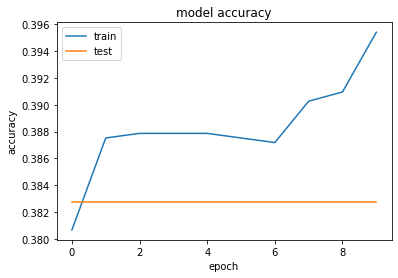

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

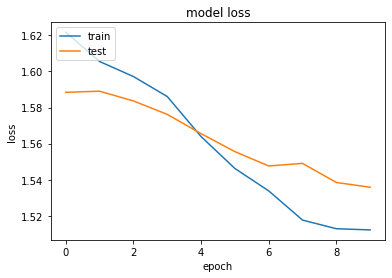

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Gerrit Cole

In [0]:
cole = df.loc[df['pitcher_id'] == 543037]
cole.shape

(3270, 17)

In [0]:
cole = cole.drop(['ab_id', 'b_score', 'p_score', 'g_id', 'pitcher_id', 'Unnamed: 0'], axis=1)


In [0]:
cole['event'].fillna('Pitch Thrown', inplace=True)


In [0]:
cole.isna().any()

outs          False
pitch_num     False
pitch_type    False
stand         False
event         False
top           False
inning        False
count         False
run diff      False
HSS           False
next_pitch    False
dtype: bool

In [0]:
cole['pitch_type'].value_counts()

FF         1680
SL          755
KC          510
CH          243
FT           80
Unknown       2
Name: pitch_type, dtype: int64

In [0]:
cole['next_pitch'].value_counts()

FF         1607
SL          755
KC          485
CH          256
FT           92
CU           29
SI           28
FC           15
Unknown       3
Name: next_pitch, dtype: int64

In [0]:
cole = cole[cole.pitch_type != 'Unknown']
cole = cole[cole.next_pitch != 'Unknown']
cole = cole[cole.next_pitch != 'CU']
cole = cole[cole.next_pitch != 'SI']
cole = cole[cole.next_pitch != 'FC']

In [0]:
cole['pitch_type'].value_counts()

FF    1645
SL     727
KC     502
CH     239
FT      80
Name: pitch_type, dtype: int64

In [0]:
cole['next_pitch'].value_counts()

FF    1606
SL     755
KC     485
CH     256
FT      91
Name: next_pitch, dtype: int64

In [0]:
x = cole.drop(['next_pitch'], axis=1)

In [0]:
y = cole['next_pitch']

In [0]:
print('X Shape', x.shape)
print ('Y Shape', y.shape)

X Shape (3193, 10)
Y Shape (3193,)


In [0]:
x.head()

,outs,pitch_num,pitch_type,stand,event,top,inning,count,run diff,HSS
5676,0.0,1.0,FF,L,Pitch Thrown,0.0,1.0,0.0-0.0,0.0,0
5677,0.0,2.0,FT,L,Pitch Thrown,0.0,1.0,0.0-1.0,0.0,0
5678,0.0,3.0,SL,L,Pitch Thrown,0.0,1.0,1.0-1.0,0.0,0
5679,0.0,4.0,FF,L,Pitch Thrown,0.0,1.0,2.0-1.0,0.0,0
5680,0.0,5.0,SL,L,Pitch Thrown,0.0,1.0,2.0-1.0,0.0,0


In [0]:
#Time to encode Y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_y)


In [0]:
x = pd.get_dummies(x, columns=['outs', 'pitch_type', 'stand', 'event', 'top', 'inning', 'count', 'HSS'])

In [0]:
x.shape

(3193, 51)

In [0]:
dummy_y

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [0]:
#split data into train/test

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.2, random_state=92)

In [0]:
print('X Train Shape', x_train.shape)
print('X Test Shape', x_test.shape)
print('Y Train Shape', y_train.shape)
print('Y Test Shape', y_test.shape)

X Train Shape (2554, 51)
X Test Shape (639, 51)
Y Train Shape (2554, 5)
Y Test Shape (639, 5)


In [0]:
model = Sequential()
model.add(Dense(102, input_dim=51, kernel_initializer = 'uniform', activation='hard_sigmoid'))
#model.add(Dropout(0.3))
model.add(Dense(51, activation='hard_sigmoid'))
#model.add(Dropout(0.3))
model.add(Dense(25, activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='sigmoid'))

In [0]:
#optimizer = keras.optimizers.adam(lr=0.3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

Train on 2554 samples, validate on 639 samples
Epoch 1/10
2554/2554 [==============================] - 1s 299us/step - loss: 1.3559 - accuracy: 0.4706 - val_loss: 1.3088 - val_accuracy: 0.5211
Epoch 2/10
2554/2554 [==============================] - 1s 205us/step - loss: 1.2944 - accuracy: 0.4984 - val_loss: 1.3077 - val_accuracy: 0.5211
Epoch 3/10
2554/2554 [==============================] - 1s 196us/step - loss: 1.2869 - accuracy: 0.4984 - val_loss: 1.3059 - val_accuracy: 0.5211
Epoch 4/10
2554/2554 [==============================] - 0s 194us/step - loss: 1.2921 - accuracy: 0.4984 - val_loss: 1.3060 - val_accuracy: 0.5211
Epoch 5/10
2554/2554 [==============================] - 1s 211us/step - loss: 1.2854 - accuracy: 0.4984 - val_loss: 1.3070 - val_accuracy: 0.5211
Epoch 6/10
2554/2554 [==============================] - 1s 217us/step - loss: 1.2844 - accuracy: 0.4984 - val_loss: 1.3099 - val_accuracy: 0.5211
Epoch 7/10
2554/2554 [==============================] - 1s 246us/step - loss:

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 102)               5304      
_________________________________________________________________
dense_18 (Dense)             (None, 51)                5253      
_________________________________________________________________
dense_19 (Dense)             (None, 25)                1300      
_________________________________________________________________
dropout_9 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 130       
Total params: 11,987
Trainable params: 11,987
Non-trainable params: 0
_________________________________________________________________


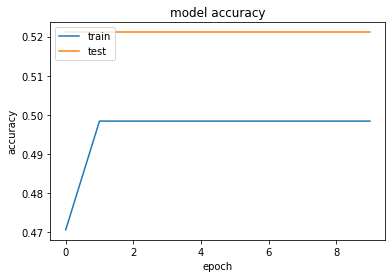

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

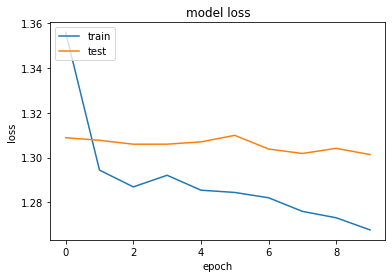

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Lucas Giolitto

In [0]:
giolitto = df.loc[df['pitcher_id'] == 608337]
giolitto.shape

(2814, 17)

In [0]:
giolitto = giolitto.drop(['ab_id', 'b_score', 'p_score', 'g_id', 'pitcher_id', 'Unnamed: 0'], axis=1)


In [0]:
giolitto['event'].fillna('Pitch Thrown', inplace=True)


In [0]:
giolitto.isna().any()

outs          False
pitch_num     False
pitch_type    False
stand         False
event         False
top           False
inning        False
count         False
run diff      False
HSS           False
next_pitch    False
dtype: bool

In [0]:
giolitto['pitch_type'].value_counts()

FF         1546
CH          734
SL          414
CU          116
Unknown       4
Name: pitch_type, dtype: int64

In [0]:
giolitto['next_pitch'].value_counts()

FF         1509
CH          717
SL          410
CU          111
SI           24
FT           15
FC           11
KC            8
Unknown       4
KN            3
FS            2
Name: next_pitch, dtype: int64

In [0]:
giolitto = giolitto[giolitto.pitch_type != 'Unknown']
giolitto = giolitto[giolitto.next_pitch != 'Unknown']
giolitto = giolitto[giolitto.next_pitch != 'SI']
giolitto = giolitto[giolitto.next_pitch != 'FT']
giolitto = giolitto[giolitto.next_pitch != 'FC']
giolitto = giolitto[giolitto.next_pitch != 'KC']
giolitto = giolitto[giolitto.next_pitch != 'KN']
giolitto = giolitto[giolitto.next_pitch != 'FS']

In [0]:
giolitto['pitch_type'].value_counts()

FF    1510
CH     715
SL     406
CU     115
Name: pitch_type, dtype: int64

In [0]:
giolitto['next_pitch'].value_counts()

FF    1509
CH     717
SL     409
CU     111
Name: next_pitch, dtype: int64

In [0]:
x = giolitto.drop(['next_pitch'], axis=1)

In [0]:
y = giolitto['next_pitch']

In [0]:
print('X Shape', x.shape)
print ('Y Shape', y.shape)

X Shape (2746, 10)
Y Shape (2746,)


In [0]:
x.head()

,outs,pitch_num,pitch_type,stand,event,top,inning,count,run diff,HSS
12493,0.0,1.0,FF,R,Pitch Thrown,0.0,1.0,0.0-0.0,0.0,0
12494,0.0,2.0,FF,R,Pitch Thrown,0.0,1.0,1.0-0.0,0.0,0
12495,0.0,3.0,FF,R,Pitch Thrown,0.0,1.0,2.0-0.0,0.0,0
12496,0.0,4.0,FF,R,Pitch Thrown,0.0,1.0,3.0-0.0,0.0,0
12497,0.0,1.0,FF,L,Pitch Thrown,0.0,1.0,0.0-0.0,0.0,0


In [0]:
#Time to encode Y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_y)


In [0]:
x = pd.get_dummies(x, columns=['outs', 'pitch_type', 'stand', 'event', 'top', 'inning', 'count', 'HSS'])

In [0]:
x.shape

(2746, 49)

In [0]:
dummy_y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [0]:
#split data into train/test

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.2, random_state=92)

In [0]:
print('X Train Shape', x_train.shape)
print('X Test Shape', x_test.shape)
print('Y Train Shape', y_train.shape)
print('Y Test Shape', y_test.shape)

X Train Shape (2196, 49)
X Test Shape (550, 49)
Y Train Shape (2196, 4)
Y Test Shape (550, 4)


In [0]:
model = Sequential()
model.add(Dense(98, input_dim=49, kernel_initializer = 'uniform', activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(49, activation='hard_sigmoid'))
#model.add(Dropout(0.3))
model.add(Dense(25, activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='sigmoid'))

In [0]:
#optimizer = keras.optimizers.adam(lr=0.3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

Train on 2196 samples, validate on 550 samples
Epoch 1/10
2196/2196 [==============================] - 1s 337us/step - loss: 1.1426 - accuracy: 0.5405 - val_loss: 1.0666 - val_accuracy: 0.5800
Epoch 2/10
2196/2196 [==============================] - 0s 198us/step - loss: 1.1163 - accuracy: 0.5419 - val_loss: 1.0694 - val_accuracy: 0.5800
Epoch 3/10
2196/2196 [==============================] - 1s 230us/step - loss: 1.1118 - accuracy: 0.5414 - val_loss: 1.0623 - val_accuracy: 0.5800
Epoch 4/10
2196/2196 [==============================] - 0s 227us/step - loss: 1.1119 - accuracy: 0.5419 - val_loss: 1.0652 - val_accuracy: 0.5800
Epoch 5/10
2196/2196 [==============================] - 1s 228us/step - loss: 1.1086 - accuracy: 0.5419 - val_loss: 1.0564 - val_accuracy: 0.5800
Epoch 6/10
2196/2196 [==============================] - 0s 215us/step - loss: 1.1023 - accuracy: 0.5419 - val_loss: 1.0568 - val_accuracy: 0.5800
Epoch 7/10
2196/2196 [==============================] - 0s 223us/step - loss:

In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 98)                4900      
_________________________________________________________________
dropout_12 (Dropout)         (None, 98)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 49)                4851      
_________________________________________________________________
dense_27 (Dense)             (None, 25)                1250      
_________________________________________________________________
dropout_13 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 104       
Total params: 11,105
Trainable params: 11,105
Non-trainable params: 0
__________________________________________________

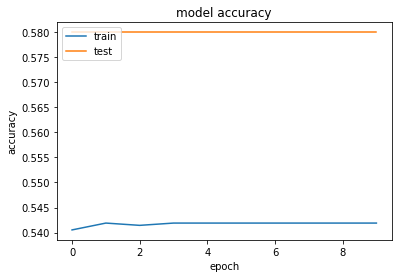

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

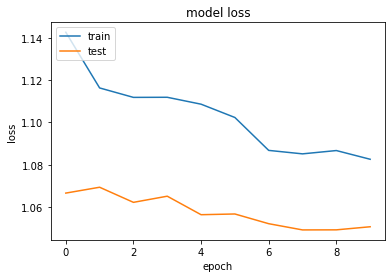

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Kyle Hendricks

In [0]:
hendricks = df.loc[df['pitcher_id'] == 543294]
hendricks.shape

(2702, 17)

In [0]:
hendricks = hendricks.drop(['ab_id', 'b_score', 'p_score', 'g_id', 'pitcher_id', 'Unnamed: 0'], axis=1)


In [0]:
hendricks['event'].fillna('Pitch Thrown', inplace=True)


In [0]:
hendricks.isna().any()

outs          False
pitch_num     False
pitch_type    False
stand         False
event         False
top           False
inning        False
count         False
run diff      False
HSS           False
next_pitch    False
dtype: bool

In [0]:
hendricks['pitch_type'].value_counts()

SI         1120
CH          755
FF          552
CU          263
Unknown      12
Name: pitch_type, dtype: int64

In [0]:
hendricks['next_pitch'].value_counts()

SI         1043
CH          761
FF          554
CU          256
SL           27
FT           26
FC           12
Unknown      12
KC           10
FS            1
Name: next_pitch, dtype: int64

In [0]:
hendricks = hendricks[hendricks.pitch_type != 'Unknown']
hendricks = hendricks[hendricks.next_pitch != 'Unknown']
hendricks = hendricks[hendricks.next_pitch != 'SL']
hendricks = hendricks[hendricks.next_pitch != 'FT']
hendricks = hendricks[hendricks.next_pitch != 'FC']
hendricks = hendricks[hendricks.next_pitch != 'KC']
hendricks = hendricks[hendricks.next_pitch != 'FS']

In [0]:
hendricks['pitch_type'].value_counts()

SI    1093
CH     723
FF     539
CU     255
Name: pitch_type, dtype: int64

In [0]:
hendricks['next_pitch'].value_counts()

SI    1042
CH     760
FF     553
CU     255
Name: next_pitch, dtype: int64

In [0]:
x = hendricks.drop(['next_pitch'], axis=1)

In [0]:
y = hendricks['next_pitch']

In [0]:
print('X Shape', x.shape)
print ('Y Shape', y.shape)

X Shape (2610, 10)
Y Shape (2610,)


In [0]:
x.head()

,outs,pitch_num,pitch_type,stand,event,top,inning,count,run diff,HSS
16756,0.0,1.0,FF,L,Pitch Thrown,0.0,1.0,0.0-0.0,0.0,0
16757,0.0,2.0,CH,L,Pitch Thrown,0.0,1.0,0.0-0.0,0.0,0
16758,0.0,3.0,CH,L,Pitch Thrown,0.0,1.0,0.0-0.0,0.0,0
16759,0.0,1.0,SI,R,Pitch Thrown,0.0,1.0,0.0-0.0,1.0,0
16760,0.0,2.0,SI,R,Pitch Thrown,0.0,1.0,0.0-0.0,1.0,0


In [0]:
#Time to encode Y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_y)


In [0]:
x = pd.get_dummies(x, columns=['outs', 'pitch_type', 'stand', 'event', 'top', 'inning', 'count', 'HSS'])

In [0]:
x.shape

(2610, 55)

In [0]:
dummy_y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [0]:
#split data into train/test

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.2, random_state=92)

In [0]:
print('X Train Shape', x_train.shape)
print('X Test Shape', x_test.shape)
print('Y Train Shape', y_train.shape)
print('Y Test Shape', y_test.shape)

X Train Shape (2088, 55)
X Test Shape (522, 55)
Y Train Shape (2088, 4)
Y Test Shape (522, 4)


In [0]:
model = Sequential()
model.add(Dense(110, input_dim=55, kernel_initializer = 'uniform', activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(55, activation='hard_sigmoid'))
#model.add(Dropout(0.3))
model.add(Dense(25, activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='sigmoid'))

In [0]:
#optimizer = keras.optimizers.adam(lr=0.3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

Train on 2088 samples, validate on 522 samples
Epoch 1/10
2088/2088 [==============================] - 1s 371us/step - loss: 1.3267 - accuracy: 0.3448 - val_loss: 1.2770 - val_accuracy: 0.4215
Epoch 2/10
2088/2088 [==============================] - 0s 230us/step - loss: 1.2898 - accuracy: 0.3898 - val_loss: 1.2753 - val_accuracy: 0.4215
Epoch 3/10
2088/2088 [==============================] - 0s 214us/step - loss: 1.2932 - accuracy: 0.3884 - val_loss: 1.2768 - val_accuracy: 0.4215
Epoch 4/10
2088/2088 [==============================] - 0s 217us/step - loss: 1.2850 - accuracy: 0.3951 - val_loss: 1.2690 - val_accuracy: 0.4215
Epoch 5/10
2088/2088 [==============================] - 1s 250us/step - loss: 1.2662 - accuracy: 0.4119 - val_loss: 1.2404 - val_accuracy: 0.4387
Epoch 6/10
2088/2088 [==============================] - 0s 224us/step - loss: 1.2463 - accuracy: 0.4353 - val_loss: 1.2110 - val_accuracy: 0.5038
Epoch 7/10
2088/2088 [==============================] - 0s 209us/step - loss:

In [0]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 110)               6160      
_________________________________________________________________
dropout_14 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 55)                6105      
_________________________________________________________________
dense_31 (Dense)             (None, 25)                1400      
_________________________________________________________________
dropout_15 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 104       
Total params: 13,769
Trainable params: 13,769
Non-trainable params: 0
__________________________________________________

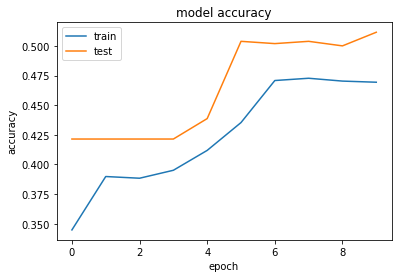

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

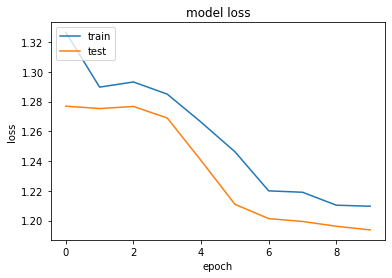

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#Hyun-Jin Ryu

In [0]:
ryu = df.loc[df['pitcher_id'] == 547943]
ryu.shape

(2713, 17)

In [0]:
ryu = ryu.drop(['ab_id', 'b_score', 'p_score', 'g_id', 'pitcher_id', 'Unnamed: 0'], axis=1)


In [0]:
ryu['event'].fillna('Pitch Thrown', inplace=True)


In [0]:
ryu.isna().any()

outs          False
pitch_num     False
pitch_type    False
stand         False
event         False
top           False
inning        False
count         False
run diff      False
HSS           False
next_pitch    False
dtype: bool

In [0]:
ryu['pitch_type'].value_counts()

CH         742
FF         738
FC         525
FT         361
CU         330
Unknown      9
SL           8
Name: pitch_type, dtype: int64

In [0]:
ryu['next_pitch'].value_counts()

FF         783
CH         743
FC         511
CU         312
FT         305
SL          29
Unknown     10
KC           9
SI           9
FS           2
Name: next_pitch, dtype: int64

In [0]:
ryu = ryu[ryu.pitch_type != 'Unknown']
ryu = ryu[ryu.next_pitch != 'Unknown']
ryu = ryu[ryu.next_pitch != 'KC']
ryu = ryu[ryu.next_pitch != 'SI']
ryu = ryu[ryu.next_pitch != 'FS']

In [0]:
ryu['pitch_type'].value_counts()

CH    736
FF    730
FC    523
FT    357
CU    326
SL      8
Name: pitch_type, dtype: int64

In [0]:
ryu['next_pitch'].value_counts()

FF    781
CH    743
FC    510
CU    312
FT    305
SL     29
Name: next_pitch, dtype: int64

In [0]:
x = ryu.drop(['next_pitch'], axis=1)

In [0]:
y = ryu['next_pitch']

In [0]:
print('X Shape', x.shape)
print ('Y Shape', y.shape)

X Shape (2680, 10)
Y Shape (2680,)


In [0]:
x.head()

,outs,pitch_num,pitch_type,stand,event,top,inning,count,run diff,HSS
221,0.0,1.0,FF,R,Pitch Thrown,1.0,1.0,0.0-0.0,0.0,0
222,0.0,2.0,FC,R,Pitch Thrown,1.0,1.0,0.0-0.0,0.0,0
223,0.0,3.0,FF,R,Pitch Thrown,1.0,1.0,1.0-0.0,0.0,0
224,0.0,4.0,FF,R,Pitch Thrown,1.0,1.0,2.0-0.0,0.0,0
225,0.0,5.0,FF,R,Pitch Thrown,1.0,1.0,3.0-0.0,0.0,0


In [0]:
#Time to encode Y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_y)


In [0]:
x = pd.get_dummies(x, columns=['outs', 'pitch_type', 'stand', 'event', 'top', 'inning', 'count', 'HSS'])

In [0]:
x.shape

(2680, 53)

In [0]:
dummy_y

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [0]:
#split data into train/test

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.2, random_state=92)

In [0]:
print('X Train Shape', x_train.shape)
print('X Test Shape', x_test.shape)
print('Y Train Shape', y_train.shape)
print('Y Test Shape', y_test.shape)

X Train Shape (2144, 53)
X Test Shape (536, 53)
Y Train Shape (2144, 6)
Y Test Shape (536, 6)


In [0]:
model = Sequential()
model.add(Dense(106, input_dim=53, kernel_initializer = 'uniform', activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(53, activation='hard_sigmoid'))
model.add(Dense(25, activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

In [0]:
#optimizer = keras.optimizers.adam(lr=0.3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

Train on 2144 samples, validate on 536 samples
Epoch 1/10
2144/2144 [==============================] - 1s 416us/step - loss: 1.6327 - accuracy: 0.2691 - val_loss: 1.5681 - val_accuracy: 0.2854
Epoch 2/10
2144/2144 [==============================] - 1s 266us/step - loss: 1.6008 - accuracy: 0.2752 - val_loss: 1.5629 - val_accuracy: 0.2743
Epoch 3/10
2144/2144 [==============================] - 1s 282us/step - loss: 1.5935 - accuracy: 0.2789 - val_loss: 1.5674 - val_accuracy: 0.2743
Epoch 4/10
2144/2144 [==============================] - 1s 259us/step - loss: 1.5945 - accuracy: 0.2836 - val_loss: 1.5618 - val_accuracy: 0.2854
Epoch 5/10
2144/2144 [==============================] - 1s 239us/step - loss: 1.6010 - accuracy: 0.2799 - val_loss: 1.5638 - val_accuracy: 0.2743
Epoch 6/10
2144/2144 [==============================] - 1s 244us/step - loss: 1.5966 - accuracy: 0.2882 - val_loss: 1.5647 - val_accuracy: 0.2854
Epoch 7/10
2144/2144 [==============================] - 1s 285us/step - loss:

In [0]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 106)               5724      
_________________________________________________________________
dropout_16 (Dropout)         (None, 106)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 53)                5671      
_________________________________________________________________
dense_35 (Dense)             (None, 25)                1350      
_________________________________________________________________
dropout_17 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 6)                 156       
Total params: 12,901
Trainable params: 12,901
Non-trainable params: 0
__________________________________________________

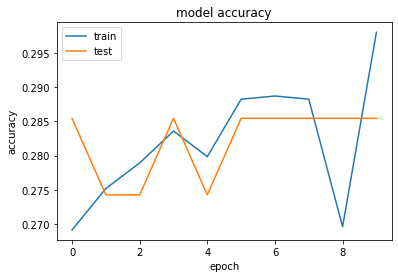

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

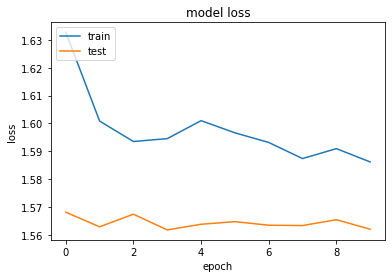

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#Luis Castillo

In [0]:
castillo = df.loc[df['pitcher_id'] == 622491]
castillo.shape

(3156, 17)

In [0]:
castillo = castillo.drop(['ab_id', 'b_score', 'p_score', 'g_id', 'pitcher_id', 'Unnamed: 0'], axis=1)


In [0]:
castillo['event'].fillna('Pitch Thrown', inplace=True)


In [0]:
castillo.isna().any()

outs          False
pitch_num     False
pitch_type    False
stand         False
event         False
top           False
inning        False
count         False
run diff      False
HSS           False
next_pitch    False
dtype: bool

In [0]:
castillo['pitch_type'].value_counts()

CH         998
FF         911
FT         639
SL         519
Unknown     89
Name: pitch_type, dtype: int64

In [0]:
castillo['next_pitch'].value_counts()

CH         1001
FF          904
FT          605
SL          489
Unknown      89
CU           26
SI           21
FC           18
FS            2
KC            1
Name: next_pitch, dtype: int64

In [0]:
castillo = castillo[castillo.pitch_type != 'Unknown']
castillo = castillo[castillo.next_pitch != 'Unknown']
castillo = castillo[castillo.next_pitch != 'CU']
castillo = castillo[castillo.next_pitch != 'SI']
castillo = castillo[castillo.next_pitch != 'FC']
castillo = castillo[castillo.next_pitch != 'FS']
castillo = castillo[castillo.next_pitch != 'KC']

In [0]:
castillo['pitch_type'].value_counts()

CH    968
FF    900
FT    621
SL    508
Name: pitch_type, dtype: int64

In [0]:
castillo['next_pitch'].value_counts()

CH    1001
FF     902
FT     605
SL     489
Name: next_pitch, dtype: int64

In [0]:
x = castillo.drop(['next_pitch'], axis=1)

In [0]:
y = castillo['next_pitch']

In [0]:
print('X Shape', x.shape)
print ('Y Shape', y.shape)

X Shape (2997, 10)
Y Shape (2997,)


In [0]:
x.head()

,outs,pitch_num,pitch_type,stand,event,top,inning,count,run diff,HSS
3291,0.0,1.0,FF,L,Groundout,1.0,1.0,0.0-0.0,0.0,0
3292,1.0,1.0,FF,L,Pitch Thrown,1.0,1.0,0.0-0.0,0.0,0
3293,1.0,2.0,CH,L,Pitch Thrown,1.0,1.0,0.0-0.0,0.0,0
3294,1.0,3.0,FF,L,Pitch Thrown,1.0,1.0,0.0-1.0,0.0,0
3295,1.0,4.0,CH,L,Strikeout,1.0,1.0,0.0-1.0,0.0,0


In [0]:
#Time to encode Y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_y)


In [0]:
x = pd.get_dummies(x, columns=['outs', 'pitch_type', 'stand', 'event', 'top', 'inning', 'count', 'HSS'])

In [0]:
x.shape

(2997, 49)

In [0]:
dummy_y

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [0]:
#split data into train/test

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.2, random_state=92)

In [0]:
print('X Train Shape', x_train.shape)
print('X Test Shape', x_test.shape)
print('Y Train Shape', y_train.shape)
print('Y Test Shape', y_test.shape)

X Train Shape (2397, 49)
X Test Shape (600, 49)
Y Train Shape (2397, 4)
Y Test Shape (600, 4)


In [0]:
model = Sequential()
model.add(Dense(98, input_dim=49, kernel_initializer = 'uniform', activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(49, activation='hard_sigmoid'))
model.add(Dense(25, activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='sigmoid'))

In [0]:
#optimizer = keras.optimizers.adam(lr=0.3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

Train on 2397 samples, validate on 600 samples
Epoch 1/10
2397/2397 [==============================] - 1s 354us/step - loss: 1.3656 - accuracy: 0.3029 - val_loss: 1.3548 - val_accuracy: 0.3300
Epoch 2/10
2397/2397 [==============================] - 1s 252us/step - loss: 1.3483 - accuracy: 0.3404 - val_loss: 1.3546 - val_accuracy: 0.3300
Epoch 3/10
2397/2397 [==============================] - 1s 261us/step - loss: 1.3482 - accuracy: 0.3346 - val_loss: 1.3582 - val_accuracy: 0.3300
Epoch 4/10
2397/2397 [==============================] - 1s 273us/step - loss: 1.3493 - accuracy: 0.3179 - val_loss: 1.3526 - val_accuracy: 0.3300
Epoch 5/10
2397/2397 [==============================] - 1s 238us/step - loss: 1.3438 - accuracy: 0.3333 - val_loss: 1.3487 - val_accuracy: 0.3300
Epoch 6/10
2397/2397 [==============================] - 1s 252us/step - loss: 1.3380 - accuracy: 0.3454 - val_loss: 1.3468 - val_accuracy: 0.3317
Epoch 7/10
2397/2397 [==============================] - 1s 236us/step - loss:

In [0]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 98)                4900      
_________________________________________________________________
dropout_20 (Dropout)         (None, 98)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 49)                4851      
_________________________________________________________________
dense_43 (Dense)             (None, 25)                1250      
_________________________________________________________________
dropout_21 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 104       
Total params: 11,105
Trainable params: 11,105
Non-trainable params: 0
_________________________________________________

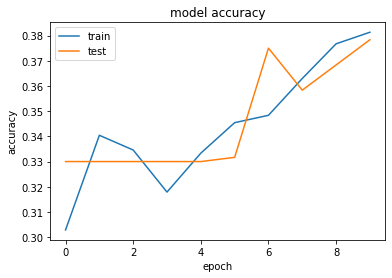

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

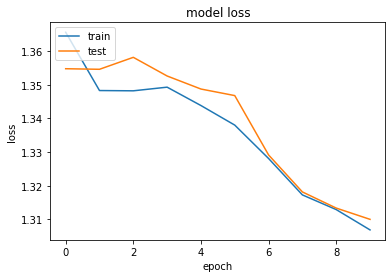

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#Marcus Stroman

In [0]:
stroman = df.loc[df['pitcher_id'] == 573186]
stroman.shape

(3049, 17)

In [0]:
stroman = stroman.drop(['ab_id', 'b_score', 'p_score', 'g_id', 'pitcher_id', 'Unnamed: 0'], axis=1)


In [0]:
stroman['event'].fillna('Pitch Thrown', inplace=True)


In [0]:
stroman.isna().any()

outs          False
pitch_num     False
pitch_type    False
stand         False
event         False
top           False
inning        False
count         False
run diff      False
HSS           False
next_pitch    False
dtype: bool

In [0]:
stroman['pitch_type'].value_counts()

FT         1106
SL          939
FC          735
CH          161
FF           73
CU           30
Unknown       5
Name: pitch_type, dtype: int64

In [0]:
stroman['next_pitch'].value_counts()

FT         1043
SL          906
FC          720
CH          164
FF          150
CU           52
SI            6
Unknown       5
KC            3
Name: next_pitch, dtype: int64

In [0]:
stroman = stroman[stroman.pitch_type != 'Unknown']
stroman = stroman[stroman.next_pitch != 'Unknown']
stroman = stroman[stroman.next_pitch != 'SI']
stroman = stroman[stroman.next_pitch != 'KC']

In [0]:
stroman['pitch_type'].value_counts()

FT    1104
SL     935
FC     731
CH     160
FF      73
CU      30
Name: pitch_type, dtype: int64

In [0]:
stroman['next_pitch'].value_counts()

FT    1043
SL     905
FC     720
CH     164
FF     150
CU      51
Name: next_pitch, dtype: int64

In [0]:
x = stroman.drop(['next_pitch'], axis=1)

In [0]:
y = stroman['next_pitch']

In [0]:
print('X Shape', x.shape)
print ('Y Shape', y.shape)

X Shape (3033, 10)
Y Shape (3033,)


In [0]:
x.head()

,outs,pitch_num,pitch_type,stand,event,top,inning,count,run diff,HSS
2503,0.0,1.0,FT,R,Pitch Thrown,1.0,1.0,0.0-0.0,0.0,0
2504,0.0,2.0,FT,R,Pitch Thrown,1.0,1.0,1.0-0.0,0.0,0
2505,0.0,3.0,FT,R,Pitch Thrown,1.0,1.0,2.0-0.0,0.0,0
2506,0.0,4.0,FF,R,Pitch Thrown,1.0,1.0,3.0-0.0,0.0,0
2507,0.0,1.0,FT,R,Forceout,1.0,1.0,0.0-0.0,0.0,0


In [0]:
#Time to encode Y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_y)


In [0]:
x = pd.get_dummies(x, columns=['outs', 'pitch_type', 'stand', 'event', 'top', 'inning', 'count', 'HSS'])

In [0]:
x.shape

(3033, 57)

In [0]:
dummy_y

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [0]:
#split data into train/test

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.2, random_state=92)

In [0]:
print('X Train Shape', x_train.shape)
print('X Test Shape', x_test.shape)
print('Y Train Shape', y_train.shape)
print('Y Test Shape', y_test.shape)

X Train Shape (2426, 57)
X Test Shape (607, 57)
Y Train Shape (2426, 6)
Y Test Shape (607, 6)


In [0]:
model = Sequential()
model.add(Dense(104, input_dim=57, kernel_initializer = 'uniform', activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(57, activation='hard_sigmoid'))
model.add(Dense(25, activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

In [0]:
#optimizer = keras.optimizers.adam(lr=0.3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

Train on 2426 samples, validate on 607 samples
Epoch 1/10
2426/2426 [==============================] - 1s 299us/step - loss: 1.5440 - accuracy: 0.3252 - val_loss: 1.4414 - val_accuracy: 0.3657
Epoch 2/10
2426/2426 [==============================] - 1s 242us/step - loss: 1.4617 - accuracy: 0.3392 - val_loss: 1.4445 - val_accuracy: 0.3657
Epoch 3/10
2426/2426 [==============================] - 1s 206us/step - loss: 1.4606 - accuracy: 0.3368 - val_loss: 1.4431 - val_accuracy: 0.3657
Epoch 4/10
2426/2426 [==============================] - 1s 219us/step - loss: 1.4554 - accuracy: 0.3203 - val_loss: 1.4409 - val_accuracy: 0.3657
Epoch 5/10
2426/2426 [==============================] - 0s 205us/step - loss: 1.4536 - accuracy: 0.3397 - val_loss: 1.4384 - val_accuracy: 0.3657
Epoch 6/10
2426/2426 [==============================] - 1s 233us/step - loss: 1.4455 - accuracy: 0.3322 - val_loss: 1.4306 - val_accuracy: 0.3657
Epoch 7/10
2426/2426 [==============================] - 1s 222us/step - loss:

In [0]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 104)               6032      
_________________________________________________________________
dropout_22 (Dropout)         (None, 104)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 57)                5985      
_________________________________________________________________
dense_47 (Dense)             (None, 25)                1450      
_________________________________________________________________
dropout_23 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 6)                 156       
Total params: 13,623
Trainable params: 13,623
Non-trainable params: 0
_________________________________________________

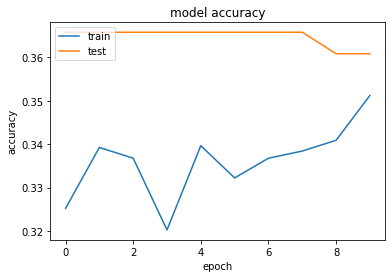

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

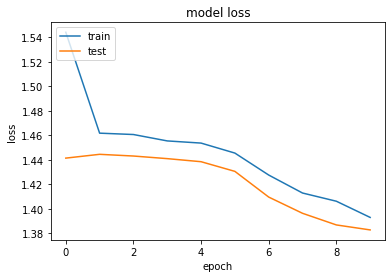

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#Yu Darvish

In [0]:
darvish = df.loc[df['pitcher_id'] == 506433]
darvish.shape

(2851, 17)

In [0]:
darvish = darvish.drop(['ab_id', 'b_score', 'p_score', 'g_id', 'pitcher_id', 'Unnamed: 0'], axis=1)


In [0]:
darvish['event'].fillna('Pitch Thrown', inplace=True)


In [0]:
darvish.isna().any()

outs          False
pitch_num     False
pitch_type    False
stand         False
event         False
top           False
inning        False
count         False
run diff      False
HSS           False
next_pitch    False
dtype: bool

In [0]:
darvish['pitch_type'].value_counts()

FC         1040
FF          763
SL          392
FT          334
CU          138
FS          108
KC           59
CH           12
Unknown       3
EP            2
Name: pitch_type, dtype: int64

In [0]:
darvish['next_pitch'].value_counts()

FC         992
FF         764
SL         383
FT         344
CU         161
FS         105
KC          65
CH          21
SI          11
Unknown      3
EP           2
Name: next_pitch, dtype: int64

In [0]:
darvish = darvish[darvish.pitch_type != 'Unknown']
darvish = darvish[darvish.next_pitch != 'Unknown']
darvish = darvish[darvish.next_pitch != 'SI']

In [0]:
darvish['pitch_type'].value_counts()

FC    1034
FF     762
SL     391
FT     332
CU     138
FS     107
KC      58
CH      12
EP       2
Name: pitch_type, dtype: int64

In [0]:
darvish['next_pitch'].value_counts()

FC    992
FF    764
SL    382
FT    344
CU    161
FS    105
KC     65
CH     21
EP      2
Name: next_pitch, dtype: int64

In [0]:
x = darvish.drop(['next_pitch'], axis=1)

In [0]:
y = darvish['next_pitch']

In [0]:
print('X Shape', x.shape)
print ('Y Shape', y.shape)

X Shape (2836, 10)
Y Shape (2836,)


In [0]:
x.head()

,outs,pitch_num,pitch_type,stand,event,top,inning,count,run diff,HSS
8446,0.0,1.0,FF,L,Pitch Thrown,0.0,1.0,0.0-0.0,3.0,0
8447,0.0,2.0,SL,L,Pitch Thrown,0.0,1.0,1.0-0.0,3.0,0
8448,0.0,3.0,FF,L,Pitch Thrown,0.0,1.0,1.0-0.0,3.0,0
8449,0.0,4.0,SL,L,Pitch Thrown,0.0,1.0,2.0-0.0,3.0,0
8450,0.0,5.0,FC,L,Strikeout,0.0,1.0,2.0-0.0,3.0,0


In [0]:
#Time to encode Y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_y)


In [0]:
x = pd.get_dummies(x, columns=['outs', 'pitch_type', 'stand', 'event', 'top', 'inning', 'count', 'HSS'])

In [0]:
x.shape

(2836, 54)

In [0]:
dummy_y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [0]:
#split data into train/test

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.2, random_state=92)

In [0]:
print('X Train Shape', x_train.shape)
print('X Test Shape', x_test.shape)
print('Y Train Shape', y_train.shape)
print('Y Test Shape', y_test.shape)

X Train Shape (2268, 54)
X Test Shape (568, 54)
Y Train Shape (2268, 9)
Y Test Shape (568, 9)


In [0]:
model = Sequential()
model.add(Dense(108, input_dim=54, kernel_initializer = 'uniform', activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(54, activation='hard_sigmoid'))
model.add(Dense(27, activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(9, activation='sigmoid'))

In [0]:
#optimizer = keras.optimizers.adam(lr=0.3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

Train on 2268 samples, validate on 568 samples
Epoch 1/10
2268/2268 [==============================] - 1s 306us/step - loss: 1.8330 - accuracy: 0.3003 - val_loss: 1.6965 - val_accuracy: 0.3046
Epoch 2/10
2268/2268 [==============================] - 0s 217us/step - loss: 1.7015 - accuracy: 0.3448 - val_loss: 1.6851 - val_accuracy: 0.3046
Epoch 3/10
2268/2268 [==============================] - 0s 192us/step - loss: 1.6902 - accuracy: 0.3611 - val_loss: 1.6914 - val_accuracy: 0.3046
Epoch 4/10
2268/2268 [==============================] - 0s 203us/step - loss: 1.6807 - accuracy: 0.3598 - val_loss: 1.6865 - val_accuracy: 0.3046
Epoch 5/10
2268/2268 [==============================] - 1s 231us/step - loss: 1.6835 - accuracy: 0.3624 - val_loss: 1.6870 - val_accuracy: 0.3046
Epoch 6/10
2268/2268 [==============================] - 1s 243us/step - loss: 1.6715 - accuracy: 0.3593 - val_loss: 1.6930 - val_accuracy: 0.3046
Epoch 7/10
2268/2268 [==============================] - 1s 283us/step - loss:

In [0]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 108)               5940      
_________________________________________________________________
dropout_24 (Dropout)         (None, 108)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 54)                5886      
_________________________________________________________________
dense_51 (Dense)             (None, 27)                1485      
_________________________________________________________________
dropout_25 (Dropout)         (None, 27)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 9)                 252       
Total params: 13,563
Trainable params: 13,563
Non-trainable params: 0
_________________________________________________

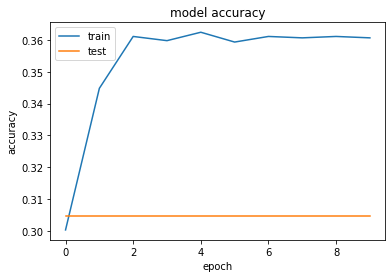

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

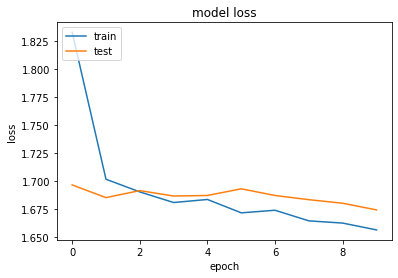

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#Let's generalize for all pitchers

In [0]:
df= df.drop(['ab_id', 'b_score', 'p_score', 'g_id', 'pitcher_id', 'Unnamed: 0'], axis=1)


In [0]:
df.columns

Index(['outs', 'pitch_num', 'pitch_type', 'stand', 'event', 'top', 'inning',
       'count', 'run diff', 'HSS', 'next_pitch'],
      dtype='object')

In [0]:
df['event'].fillna('Pitch Thrown', inplace=True)


In [0]:
df.isna().any()

outs          False
pitch_num     False
pitch_type    False
stand         False
event         False
top           False
inning        False
count         False
run diff      False
HSS           False
next_pitch    False
dtype: bool

In [0]:
df['pitch_type'].value_counts()

FF         261485
SL         127680
CH          79939
CU          64166
FT          61044
SI          55361
FC          46339
KC          15324
FS          10538
Unknown      6629
KN            200
EP             49
FO             36
Name: pitch_type, dtype: int64

In [0]:
df = df[df.pitch_type != 'Unknown']
df = df[df.next_pitch != 'Unknown']

In [0]:
df['pitch_type'].value_counts()

FF    261157
SL    127458
CH     79823
CU     64064
FT     60962
SI     55260
FC     46263
KC     15306
FS     10521
KN       199
EP        49
FO        36
Name: pitch_type, dtype: int64

In [0]:
df['next_pitch'].value_counts()

FF    261116
SL    127451
CH     79871
CU     64076
FT     60966
SI     55246
FC     46258
KC     15304
FS     10526
KN       199
EP        49
FO        36
Name: next_pitch, dtype: int64

In [0]:
x = df.drop(['next_pitch'], axis=1)

In [0]:
y = df['next_pitch']

In [0]:
print('X Shape', x.shape)
print ('Y Shape', y.shape)

X Shape (721098, 10)
Y Shape (721098,)


In [0]:
x.head()

,outs,pitch_num,pitch_type,stand,event,top,inning,count,run diff,HSS
0,0.0,1.0,FF,L,Flyout,1.0,1.0,0.0-0.0,0.0,0
1,1.0,1.0,FF,R,Pitch Thrown,1.0,1.0,0.0-0.0,0.0,0
2,1.0,2.0,SL,R,Pitch Thrown,1.0,1.0,0.0-0.0,0.0,0
3,1.0,3.0,CH,R,Pitch Thrown,1.0,1.0,0.0-1.0,0.0,0
4,1.0,4.0,CH,R,Pitch Thrown,1.0,1.0,1.0-1.0,0.0,0


In [0]:
#Time to encode Y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_y)


In [0]:
x = pd.get_dummies(x, columns=['outs', 'pitch_type', 'stand', 'event', 'top', 'inning', 'count', 'HSS'])

In [0]:
x.columns

Index(['pitch_num', 'run diff', 'outs_0.0', 'outs_1.0', 'outs_2.0',
       'pitch_type_CH', 'pitch_type_CU', 'pitch_type_EP', 'pitch_type_FC',
       'pitch_type_FF', 'pitch_type_FO', 'pitch_type_FS', 'pitch_type_FT',
       'pitch_type_KC', 'pitch_type_KN', 'pitch_type_SI', 'pitch_type_SL',
       'stand_L', 'stand_R', 'event_Batter Interference',
       'event_Bunt Groundout', 'event_Bunt Lineout', 'event_Bunt Pop Out',
       'event_Caught Stealing 2B', 'event_Caught Stealing 3B',
       'event_Caught Stealing Home', 'event_Double', 'event_Double Play',
       'event_Fan Interference', 'event_Field Error', 'event_Fielders Choice',
       'event_Fielders Choice Out', 'event_Flyout', 'event_Forceout',
       'event_Grounded Into DP', 'event_Groundout', 'event_Hit By Pitch',
       'event_Home Run', 'event_Lineout', 'event_Passed Ball',
       'event_Pickoff 1B', 'event_Pickoff 2B', 'event_Pickoff 3B',
       'event_Pickoff Caught Stealing 2B', 'event_Pickoff Caught Stealing 3B',
     

In [0]:
x.shape

(721098, 98)

In [0]:
dummy_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [0]:
#split data into train/test

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.2, random_state=92)

In [0]:
print('X Train Shape', x_train.shape)
print('X Test Shape', x_test.shape)
print('Y Train Shape', y_train.shape)
print('Y Test Shape', y_test.shape)

X Train Shape (576878, 98)
X Test Shape (144220, 98)
Y Train Shape (576878, 12)
Y Test Shape (144220, 12)


In [0]:
model = Sequential()
model.add(Dense(196, input_dim=98, kernel_initializer = 'uniform', activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(98, activation='hard_sigmoid'))
model.add(Dense(49, activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(12, activation='sigmoid'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

Train on 576878 samples, validate on 144220 samples
Epoch 1/10
576878/576878 [==============================] - 162s 280us/step - loss: 1.7098 - accuracy: 0.4025 - val_loss: 1.6669 - val_accuracy: 0.4119
Epoch 2/10
576878/576878 [==============================] - 154s 266us/step - loss: 1.6751 - accuracy: 0.4098 - val_loss: 1.6593 - val_accuracy: 0.4118
Epoch 3/10
576878/576878 [==============================] - 153s 265us/step - loss: 1.6683 - accuracy: 0.4111 - val_loss: 1.6565 - val_accuracy: 0.4115
Epoch 4/10
576878/576878 [==============================] - 151s 261us/step - loss: 1.6664 - accuracy: 0.4111 - val_loss: 1.6551 - val_accuracy: 0.4119
Epoch 5/10
576878/576878 [==============================] - 161s 279us/step - loss: 1.6645 - accuracy: 0.4121 - val_loss: 1.6547 - val_accuracy: 0.4121
Epoch 6/10
576878/576878 [==============================] - 151s 262us/step - loss: 1.6632 - accuracy: 0.4121 - val_loss: 1.6552 - val_accuracy: 0.4121
Epoch 7/10
576878/576878 [==========

In [0]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 196)               19404     
_________________________________________________________________
dropout_26 (Dropout)         (None, 196)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 98)                19306     
_________________________________________________________________
dense_55 (Dense)             (None, 49)                4851      
_________________________________________________________________
dropout_27 (Dropout)         (None, 49)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 12)                600       
Total params: 44,161
Trainable params: 44,161
Non-trainable params: 0
_________________________________________________

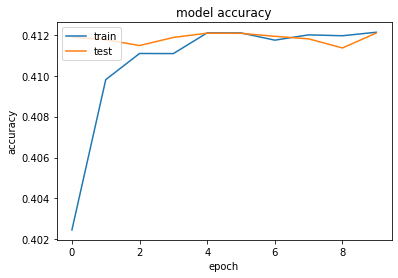

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

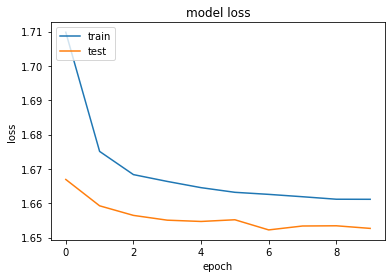

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()